In [41]:
# Importing the required packages
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [42]:
data = pd.read_csv('fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [43]:
# Separating the data into labels and features
labels, data = data['emotion'], data.drop(['emotion','Usage'], axis=1)
data.head()

,pixels
0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,151 150 147 155 148 133 111 140 170 174 182 15...
2,231 212 156 164 174 138 161 173 182 200 106 38...
3,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


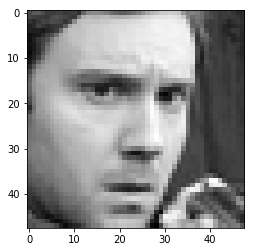

In [44]:
# Taking in the pixels of image i.e the features as a numpy array
pixel_data = data.values
pixel_data = pixel_data.astype(str)
pixel_data = np.core.defchararray.rsplit(pixel_data, sep=None, maxsplit=None)

# Visualizing the images using matplotlib
first_row = np.asarray((pixel_data)[0][0]).astype('float32')
vis_image = first_row.reshape(48,48)
plt.imshow(vis_image,cmap='gray')

### Reshaping Data

This entire part focuses on reshaping the data to be fed into the placeholder tensors which are defined further in the code. This was probably one of the hardest parts of the code and had to be done after reading an extensive amount of numpy documentation.

In [45]:
# Defining an empty list to hold values
image_data = []
# Here we parse through each element in pixel_data, extract and reshape the images and then finally resize it appropriately
for i in range(len(pixel_data)):
    row_data = np.asarray((pixel_data)[i][0]).astype('float32')
    # Normalizing the data to a value between 0 and 1
    row_data = row_data/255.0
    reshaped_row_data = row_data.reshape(48,48)
    image_data.append(reshaped_row_data)
big_data = np.vstack(image_data)
big_data.shape

'''
The shape of the array holding image data should be of size (number of image samples, height, width, 
number of input color channels)
'''
final_data = big_data.reshape(35887,48,48,1)
final_data.shape

(35887, 48, 48, 1)

In [46]:
# Now let's set aside the image data and process the labels. Since labels are categorical variables we can one-hot-encode them
encoded_labels = pd.get_dummies(labels)
encoded_labels = encoded_labels.as_matrix()
encoded_labels.shape

(35887, 7)

In [47]:
# Now to split the data into training and validation split
from sklearn.cross_validation import train_test_split

data_train, data_test, labels_train, labels_test = train_test_split(final_data, encoded_labels, test_size=0.2, random_state=0)

In [48]:
def neural_net_image_input(image_shape):
    """
    Return a Tensor for a bach of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    return tf.placeholder(tf.float32,shape=[None,image_shape[0],image_shape[1],image_shape[2]], name='x')
         


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    return tf.placeholder(tf.float32,shape=[None, n_classes], name='y')
     


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    return tf.placeholder(tf.float32, shape=None, name='keep_prob')
    


In [49]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    # TODO: Implement Function
    depth = int(x_tensor.get_shape().as_list()[3])
    weights = tf.Variable(tf.truncated_normal([conv_ksize[0],conv_ksize[1],depth,conv_num_outputs], stddev=0.05))
    bias = tf.Variable(tf.zeros([conv_num_outputs]))
    
    # Convolutional layer + Maxpooling layer
    conv_layer = tf.nn.conv2d(x_tensor, weights, strides=[1,conv_strides[0],conv_strides[1], 1], padding='SAME')
    conv_layer = tf.nn.bias_add(conv_layer, bias)
    conv_layer = tf.nn.relu(conv_layer)
    conv_layer = tf.nn.max_pool(conv_layer, ksize=[1, pool_ksize[0], pool_ksize[1],1], strides=[1, pool_strides[0], pool_strides[1], 1], padding="SAME")
    return conv_layer

In [50]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # Storing the dimensions of the tensor as a list into a variable to make it easily accessible.
    list_dim = x_tensor.get_shape().as_list()
    # Here the reshape function returns a tensor of reduced dimensionality, 2-D in this case with batch size as none.
    flattened_tensor = tf.reshape(x_tensor, [-1, list_dim[1]*list_dim[2]*list_dim[3]])
    return flattened_tensor


In [51]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    dimension = x_tensor.get_shape().as_list()[1]
    # Here I'm defining separate weights and bias for the fully connected layer..these weights live inside of this function.
    weights_full = tf.Variable(tf.truncated_normal([dimension, num_outputs], stddev = 0.05))
    bias_full = tf.Variable(tf.zeros([num_outputs]))
    # This is a regular hidden layer with weights and biases.
    fully_connected = tf.add(tf.matmul(x_tensor, weights_full),bias_full)
    fully_connected = tf.nn.relu(fully_connected)
    return fully_connected


In [52]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    new_dimension = x_tensor.get_shape().as_list()[1]
    # This is very similar to the fully connected layer.
    weights_out = tf.Variable(tf.truncated_normal([new_dimension, num_outputs], stddev = 0.05))
    bias_out = tf.Variable(tf.zeros([num_outputs]))
    #Implementing the output layer.
    output_layer = tf.add(tf.matmul(x_tensor, weights_out), bias_out)
    return output_layer

In [53]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """ 
    # The first three convolutional + maxpooling layers
    neural_net = conv2d_maxpool(x, 54, (5,5), (1,1), (2,2), (1,1))
    neural_net = conv2d_maxpool(neural_net, 64, (1,1), (2,2), (4,4), (2,2))
    neural_net = conv2d_maxpool(neural_net, 72, (2,2), (1,1), (2,2), (1,1))

    # Layer to flatten the tensor from the convolutional layers
    neural_net = flatten(neural_net)
    
    # Two fully connected layers with dropout
    neural_net = fully_conn(neural_net, 2304)
    neural_net = tf.nn.dropout(neural_net, keep_prob)
    neural_net = fully_conn(neural_net, 2304)
    neural_net = tf.nn.dropout(neural_net, keep_prob)
    neural_net = fully_conn(neural_net, 2304)
    
    # Layer for output
    neural_net = output(neural_net, 7)
    
    # TODO: return output
    return neural_net

##########Building the Neural Network##########

tf.reset_default_graph()

# Inputs
x = neural_net_image_input((48, 48, 1))
y = neural_net_label_input(7)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')


In [54]:
# Two functions to train the network and print stats 
def train_network(session, optimizer, keep_probability, features,labels):
    
    # Optimizing the neural net
    session.run(optimizer, feed_dict={x:features,y:labels, keep_prob:keep_probability})
    pass

def print_stats(session, feature_batch, label_batch, cost, accuracy):
    
    # Calculating loss and validation accuracy
    loss = sess.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.})
    valid_acc = sess.run(accuracy, feed_dict={
                x: valid_features,
                y: valid_labels,
                keep_prob: 1.})
    print("loss", loss, "valid_acc", valid_acc)
    pass    

In [55]:
# Defining the hyperparameters
epochs = 30
batch_size = 128
keep_prob = 0.5

In [56]:
# Finally let's get training 
print("Training on the data")
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        train_network(sess,optimizer, keep_prob, data_train, labels_train)
    
    print('Epoch {:>2}:  '.format(epoch + 1), end='')
    print_stats(sess, data_train, labels_train, cost, accuracy)

Training on the data


TypeError: Cannot interpret feed_dict key as Tensor: Can not convert a float into a Tensor.